# EM estimate vs direct optimization issue

Here I compare EM with `optim` in a larger simulated data-set involving 50 conditions. Example below is when `EM` and `optim` results are different and `optim` result seems better.

In [41]:
dat = readRDS('lite_data_1_artificial_mixture_1_mnm_shared_1.rds')

This data-set can be found in `mvsusieR/inst/prototypes`. Script to reproduce `mvsusie` analysis is available via `cat(dat$DSC_DEBUG$script)`. Simply copy that code and run the data generation; then run the analysis using `EM` and `optim`. I save the `X`, `Y`, `meta` and `resid_Y` data into `em_optim_difference.rds` file for ease with loading it for further investigation.

## EM result

In [25]:
result = mvsusie(X, Y, L=L, prior_variance=matrix(1,50,50), residual_variance=resid_Y, compute_objective=T, estimate_residual_variance=F, estimate_prior_variance=T, 
                estimate_prior_method='EM', track_fit=T, precompute_covariances=F)

Loading mvsusieR



In [26]:
result$V

[1] 0.1331901 0.1331220 0.1327980 0.1326600 0.1326339 0.0000000 0.0000000
 [8] 0.0000000 0.0000000 0.0000000

It seems the prior estimate are consistantly large for all effects. This data-set has 3 simulated signals,

In [3]:
which(rowSums(meta$true_coef) != 0)

[1]  43 129 162

In [4]:
meta$true_coef[which(rowSums(meta$true_coef) != 0),]

0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.000000,1.05848305,⋯,0.0000000,0.0000000,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
-0.4515795,0.2123624,-0.2313993,1.2908204,-0.1391929,0.4586080,1.1908100,0.5195072,-0.444041,0.55288239,⋯,0.8074542,1.1655001,0.55635426,0.4118661,-0.4539847,-0.3545635,0.5953944,-0.7013678,1.0421826,1.2604212
-0.7054777,-0.7788946,-0.6342108,0.7883361,-0.7436080,0.0631215,-0.7432346,-0.1296268,-1.130015,0.05221385,⋯,-0.7423689,0.5043965,0.01963459,-0.4722924,-0.2650975,-0.7530046,-0.9196253,-0.1616042,-0.2687143,-0.8154856


Clearly this will not fit a model of "all shared" effects.

Using "all shared" prior we have captured 4 effects with non-zero PIP, 2 of them are real.

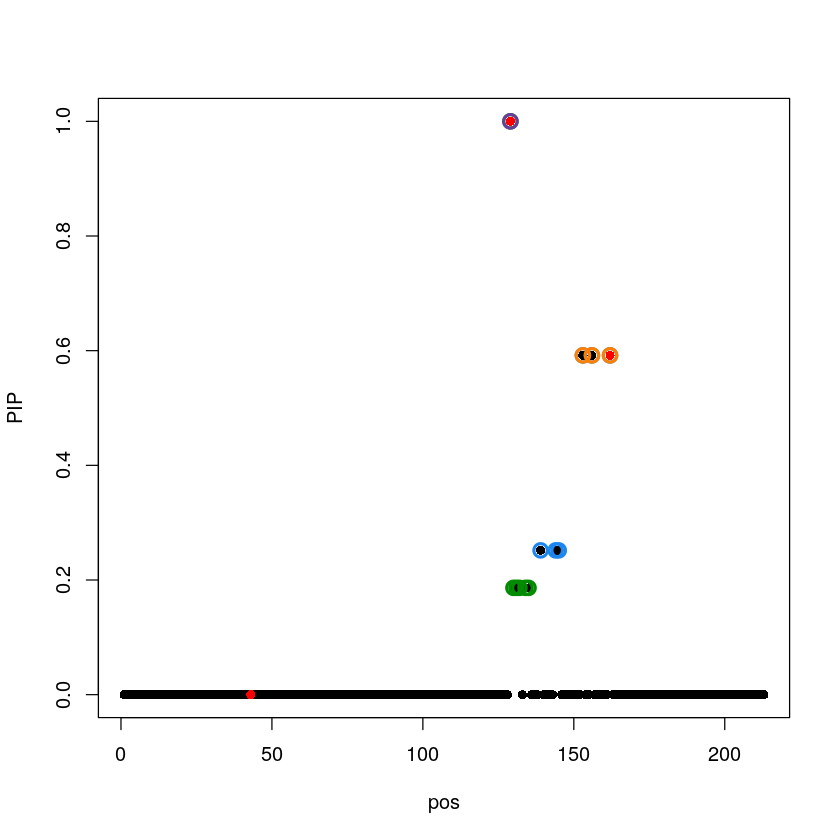

In [28]:
susieR::susie_plot(result, y='PIP',b=rowSums(meta$true_coef))

In [21]:
result$sets

,min.abs.corr,mean.abs.corr,median.abs.corr
,<dbl>,<dbl>,<dbl>
L1,1.0000000,1.0000000,1.0000000
L2,1.0000000,1.0000000,1.0000000
L4,0.9845723,0.9957145,1.0000000
L5,0.9601872,0.9800936,0.9800936


From single effect CS result, `L4` contains `L2` and `L5` contains `L1`. As a result both `L4` and `L5` appear to contain a true signals. Because of overlap between `L1` and `L5`, the 3 variables in `L1` (orange) appears to have marginal PIP 0.6 rather than 0.3. Both `L4` and `L5` have high purity.

In [12]:
result$alpha[,c(153,156,162)]

3.333333e-01,3.333333e-01,3.333333e-01
6.349176e-142,6.349176e-142,6.349176e-142
3.333311e-01,3.333311e-01,3.333311e-01
1.788361e-11,1.788361e-11,1.788361e-11
8.156961e-02,8.156961e-02,8.156961e-02
4.694836e-03,4.694836e-03,4.694836e-03
4.694836e-03,4.694836e-03,4.694836e-03
4.694836e-03,4.694836e-03,4.694836e-03
4.694836e-03,4.694836e-03,4.694836e-03
4.694836e-03,4.694836e-03,4.694836e-03


In [13]:
result$pip[c(153,156,162)]

[1] 0.5918074 0.5918074 0.5918074

Looking into the effect size,

In [17]:
result$coef[130,]

[1] 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508
 [8] 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508
[15] 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508
[22] 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508
[29] 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508
[36] 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508
[43] 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508
[50] 0.1276508

In [33]:
meta$true_coef[129,]

[1] -0.45157952  0.21236242 -0.23139926  1.29082045 -0.13919288  0.45860797
 [7]  1.19081005  0.51950718 -0.44404096  0.55288239  1.02044255 -0.67181462
[13]  0.64829538  0.90472892  0.56318766 -0.38077228  0.34985535 -0.33371293
[19]  0.35185973  0.07553337  1.74655110  0.13276429  0.79027876  1.74287184
[25] -0.35777077 -0.06698781  0.98438493  1.34967008  0.65389743  0.28627559
[31]  0.37316311  0.72586052  0.45548786  1.25877288  0.38942776 -0.53494513
[37]  0.17705649 -0.40382396  0.01924867 -0.15283342  0.80745418  1.16550010
[43]  0.55635426  0.41186611 -0.45398470 -0.35456347  0.59539439 -0.70136776
[49]  1.04218255  1.26042124

and 2nd moment of the estimated effect size, 

In [19]:
tcrossprod(result$coef[130,])[1,1]

[1] 0.01629244

In [16]:
sum(diag(tcrossprod(result$coef[130,])))/50

[1] 0.01629244

So the estimated `V` should be about this scale for the first effect.

In [24]:
result$coef[result$sets$cs$L4+1,]

0.127650810,0.127650810,0.127650810,0.127650810,0.127650810,0.127650810,0.127650810,0.127650810,0.127650810,0.127650810,⋯,0.127650810,0.127650810,0.127650810,0.127650810,0.127650810,0.127650810,0.127650810,0.127650810,0.127650810,0.127650810
0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,⋯,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951
0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,⋯,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951
0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,⋯,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951
0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,⋯,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951
0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,⋯,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951


## `optim` result

It takes long time to compute, but the PIP is cleaner. The estimated prior scalar is also smaller.

In [8]:
result2 = mvsusie(X, Y, L=L, prior_variance=matrix(1,50,50), residual_variance=resid_Y, compute_objective=T, estimate_residual_variance=F, estimate_prior_variance=T, 
                estimate_prior_method='optim', track_fit=T, precompute_covariances=F)

In [9]:
result2$V

[1] 0.0007557952 0.0009296375 0.0002614547 0.0000000000 0.0000000000
 [6] 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000

In [5]:
result2$elbo[length(result2$elbo)]

[1] -8854.683

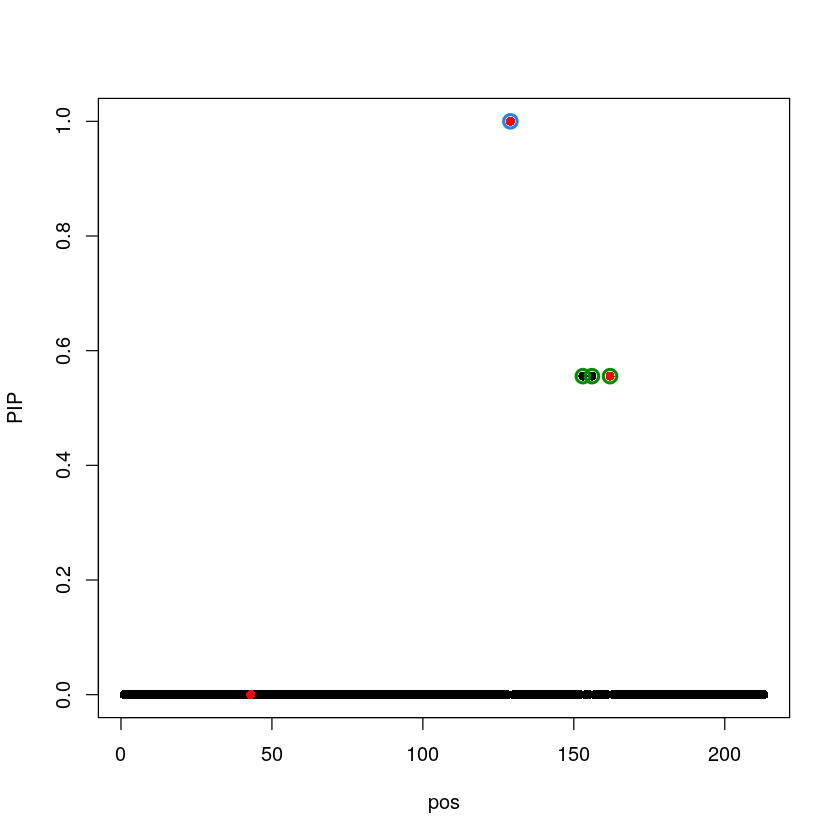

In [10]:
susieR::susie_plot(result2, y='PIP', b=rowSums(meta$true_coef))

In [20]:
result2$sets

,min.abs.corr,mean.abs.corr,median.abs.corr
,<dbl>,<dbl>,<dbl>
L1,1,1,1
L2,1,1,1


In [18]:
result2$alpha[,c(153,156,162)]

3.333333e-01,3.333333e-01,3.333333e-01
1.447861e-221,1.447861e-221,1.447861e-221
3.332946e-01,3.332946e-01,3.332946e-01
4.694836e-03,4.694836e-03,4.694836e-03
4.694836e-03,4.694836e-03,4.694836e-03
4.694836e-03,4.694836e-03,4.694836e-03
4.694836e-03,4.694836e-03,4.694836e-03
4.694836e-03,4.694836e-03,4.694836e-03
4.694836e-03,4.694836e-03,4.694836e-03
4.694836e-03,4.694836e-03,4.694836e-03


It seems to have the same issue that the first and the 3rd effects are overlapping. But because they are identical CS, we only kept one of them. 

In [28]:
susieR::susie_get_cs(result2, dedup=F)

$cs
$cs$L1
[1] 153 156 162

$cs$L2
[1] 129

$cs$L3
[1] 153 156 162


$coverage
[1] 0.95

However **such duplicate is not adjusted for when computing PIP**. This is why PIP for those 3 variables still sum to more than 1.

In [19]:
result2$pip[c(153,156,162)]

[1] 0.5555297 0.5555297 0.5555297

In [20]:
result2$coef[130,]

[1] 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662
[10] 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662
[19] 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662
[28] 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662
[37] 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662
[46] 0.15662 0.15662 0.15662 0.15662 0.15662

The estimated `V` is expected to roughly have the scale of

In [29]:
sum(diag(tcrossprod(result2$coef[130,])))/50

[1] 0.02452981

But the actual estimated `V` is a lot smaller.

**Update: the conclusion here is wrong because `coef` is after rescaling the data to original scale ... for comparsion before rescale ,see [this notebook](em_optim_difference.html).** 

## Analysis using naive canonical mixture prior

The example is a bit pathological because we knowingly use a wrong model for it. What if we use a more flexible MASH prior for it? Here I use canonical mixture with uniform weights,

In [35]:
prior = list(xUlist = mvsusieR:::create_cov_canonical(ncol(Y)))
m_init = create_mash_prior(mixture_prior = list(matrices=prior$xUlist, weights=prior$pi), null_weight=prior$null_weight, max_mixture_len=-1)
result3 = mvsusie(X, Y, L=L, prior_variance=m_init, residual_variance=resid_Y, 
                 compute_objective=T, estimate_residual_variance=F, estimate_prior_variance=T, 
                 estimate_prior_method='EM', track_fit=T, precompute_covariances=T)

In [36]:
result3$V

[1] 0.0573641369 0.0114649642 0.0002619859 0.3738287539 0.0000000000
 [6] 0.1326584581 0.0000000000 0.0000000000 0.0000000000 0.0000000000

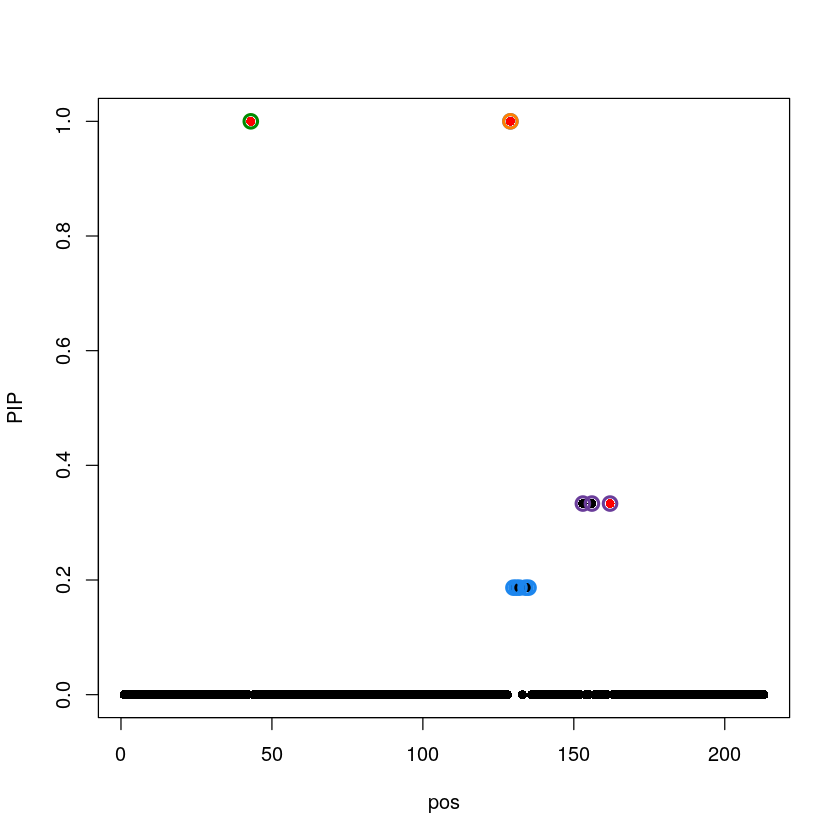

In [37]:
susieR::susie_plot(result3, y='PIP',b=rowSums(meta$true_coef))

In [38]:
result3$sets

,min.abs.corr,mean.abs.corr,median.abs.corr
,<dbl>,<dbl>,<dbl>
L1,1.0000000,1.0000000,1
L2,1.0000000,1.0000000,1
L4,1.0000000,1.0000000,1
L6,0.9845723,0.9957145,1


The result is a bit better. We have now captured all 3 variables -- the new variable in `L4` is a singleton effect.

In [41]:
max(result3$coef[44,])

[1] 1.106003

In [42]:
min(result3$coef[44,])

[1] -8.202458e-12

But there is still overlap between `L6` and `L1`, even though `L6` indeed does contain a signal. And estimated prior scalar for the 6th variable is again the magic number 0.13. Notice the purity for `L6` is quite high as we would also conclude from the plot.

## What if we use oracle mixture?

The data is simulated using `artificial_mixture`. Here I'll analyze it with the same mixture prior structure and weight, but using EM to estimate the scale.

In [45]:
names(meta$prior$oracle)

[1] "xUlist"      "pi"          "null_weight"

In [46]:
m_init = create_mash_prior(mixture_prior = list(matrices=meta$prior$oracle$xUlist, weights=meta$prior$oracle$pi), null_weight=meta$prior$oracle$null_weight, max_mixture_len=-1)
result4 = mvsusie(X, Y, L=L, prior_variance=m_init, residual_variance=resid_Y, 
                 compute_objective=T, estimate_residual_variance=F, estimate_prior_variance=T, 
                 estimate_prior_method='EM', track_fit=T, precompute_covariances=T)

In [47]:
result4$V

[1] 0.0573683484 0.0114170111 0.0002651896 0.3738270414 0.0000000000
 [6] 0.1299527025 0.0000000000 0.0000000000 0.0000000000 0.0000000000

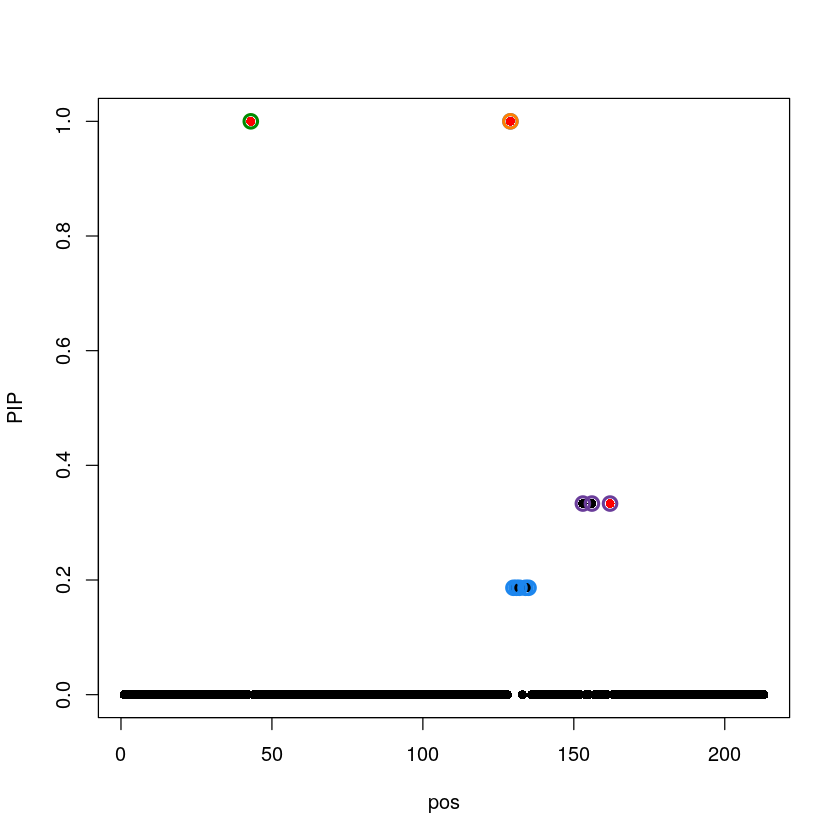

In [48]:
susieR::susie_plot(result4, y='PIP',b=rowSums(meta$true_coef))

In [49]:
result4$sets

,min.abs.corr,mean.abs.corr,median.abs.corr
,<dbl>,<dbl>,<dbl>
L1,1.0000000,1.0000000,1
L2,1.0000000,1.0000000,1
L4,1.0000000,1.0000000,1
L6,0.9845723,0.9957145,1


Unfortunately, oracle prior does not help here.

## Updated results: more EM iterations

As I looked into this example further, I noticed previous runs with EM failed to converge after maximum iterations. I therefore increase the number of iterations to 1000:

In [8]:
result5 = mvsusie(X, Y, L=L, prior_variance=mvsusieR::MashInitializer$new(list(matrix(1,50,50)),1), residual_variance=resid_Y, compute_objective=T, estimate_residual_variance=F, estimate_prior_variance=T, 
                estimate_prior_method='EM', track_fit=T, precompute_covariances=T, max_iter = 1000)

Loading mvsusieR



In [9]:
result5$V

[1] 0.0015809289 0.0009404171 0.0000000000 0.0000000000 0.0000000000
 [6] 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000

The estimated prior estimate is still different from `optim`, but ELBO here is -8847 and is higher than -8854 from `optim`.

In [6]:
result5$elbo[length(result5$elbo)]

[1] -8847.346

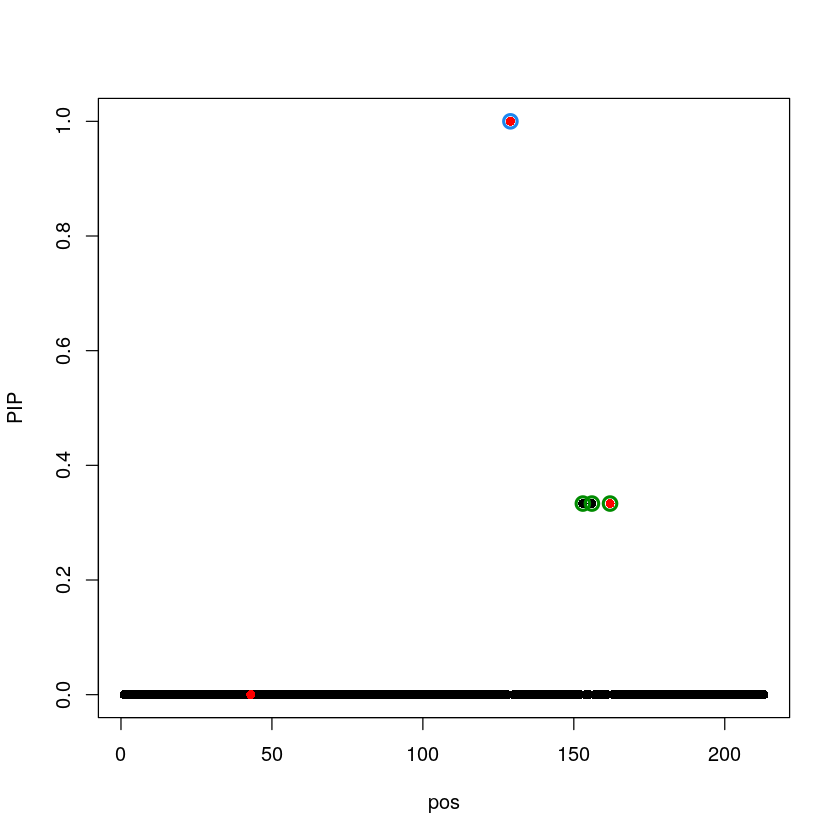

In [10]:
susieR::susie_plot(result5, y='PIP',b=rowSums(meta$true_coef))

In [11]:
result5$niter

[1] 924

In [2]:
susieR::susie_get_cs(result5, dedup=F)

$cs
$cs$L1
[1] 153 156 162

$cs$L2
[1] 129


$coverage
[1] 0.95

There is no longer overlapped CS in this analysis.

Now I try to use a naive mixture prior with more iterations. The convergence is faster, the estimated `V` is closer to the scale of the effect of variable, and ELBO is also better. All three signals have been captured.

In [19]:
prior = list(xUlist = mvsusieR:::create_cov_canonical(ncol(Y)))
m_init = create_mash_prior(mixture_prior = list(matrices=prior$xUlist, weights=prior$pi), null_weight=prior$null_weight, max_mixture_len=-1)
result6 = mvsusie(X, Y, L=L, prior_variance=m_init, residual_variance=resid_Y, 
                 compute_objective=T, estimate_residual_variance=F, estimate_prior_variance=T, 
                 estimate_prior_method='EM', track_fit=T, precompute_covariances=T, max_iter=1500)

In [20]:
result6$niter

[1] 587

In [21]:
result6$V

[1] 0.05746611 0.01146513 0.00000000 0.27751116 0.00000000 0.00000000
 [7] 0.00000000 0.00000000 0.00000000 0.00000000

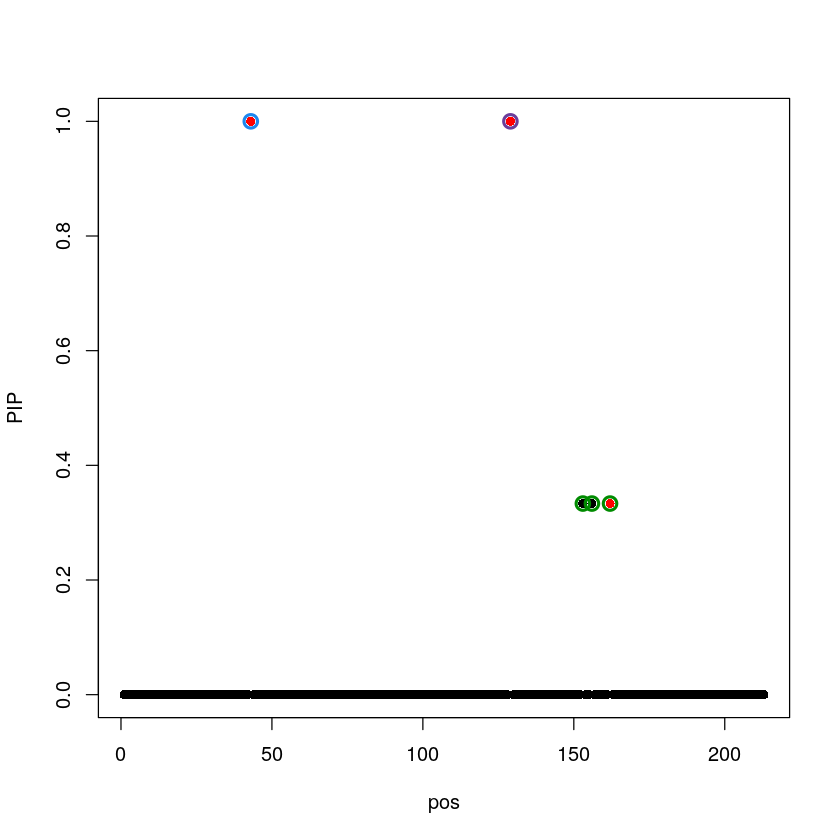

In [22]:
susieR::susie_plot(result6, y='PIP',b=rowSums(meta$true_coef))

In [23]:
result6$elbo[length(result6$elbo)]

[1] -4762.077

## Assessing impact of initialization on agreement between EM and optim

Here we run optim starting from the EM solution and vice versa, to see if that leads to agreement between these two approaches in estimating prior scalar.

First, initalize `EM` with `optim` result,

In [32]:
result7 = mvsusie(X, Y, L=L, s_init = result2, prior_variance=matrix(1,50,50), residual_variance=resid_Y, compute_objective=T, estimate_residual_variance=F, estimate_prior_variance=T, 
                estimate_prior_method='EM', track_fit=T, precompute_covariances=F)

Loading mvsusieR



In [33]:
result7$niter

[1] 2

Here is `EM` result using `optim` initialization,

In [34]:
result7$V

[1] 0.0007558448 0.0009296488 0.0002614292 0.0000000000 0.0000000000
 [6] 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000

Here is `optim` result,

In [39]:
result2$V

[1] 0.0007557952 0.0009296375 0.0002614547 0.0000000000 0.0000000000
 [6] 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000

Now initialize `optim` with `EM` result,

In [35]:
result8 = mvsusie(X, Y, L=L, s_init = result5, prior_variance=matrix(1,50,50), residual_variance=resid_Y, compute_objective=T, estimate_residual_variance=F, estimate_prior_variance=T, 
                estimate_prior_method='optim', track_fit=T, precompute_covariances=F)

In [36]:
result8$niter

[1] 2

Here is `optim` result using `EM` initialization,

In [37]:
result8$V

[1] 0.0019071576 0.0009304847 0.0000000000 0.0000000000 0.0000000000
 [6] 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000

Here is `EM` result,

In [38]:
result5$V

[1] 0.0015809289 0.0009404171 0.0000000000 0.0000000000 0.0000000000
 [6] 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000